# Strategie Evolutive

In questo notebook vedremo come funzionano le strategie evolutive $(\mu,\lambda)$ and $(\mu + \lambda)$ e le testeremo su funzioni a due dimensioni.

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [15, 15]

Funzioni di benchamrk:

- **Sfera**, definita come $$f(x, y) = x^2 + y^2$$ su $\mathbb{R}^2$ (vedremo solo l'intervallo $[-5, 5]^2$), con minimo globale in $(0,0)$.

- **Rastrigin**, definita come $$f(x, y) = 20 + x^2 - 10\cos(2\pi x) + y^2 - 10\cos(2\pi y)$$ nell'intervallo $[-5.12, 5.12]^2$, e ha un minimo globale in $(0,0)$.

- **Ackley**, definita come $$f(x, y) = -20 e^{-0.2\sqrt{0.5(x^2 - y^2)}} - e^{0.5(\cos(2\pi x) + \cos(2\pi y))} + e + 20$$ nell'intervallo $[-5,5]^2$, con minimo globale in $(0,0)$.

- **Eggholder**, definita come $$f(x,y) = -(y+47)\sin\left(\sqrt{\left|\frac{x}{2} + y + 47\right|}\right) - x\sin(\sqrt{|x-(y+47|})$$ nell'intervallo $[-512,+512]$, con minimo globale in $(512, 404.2319)$.

In [6]:
def sphere(point):
    x, y = point
    res = x**2 + y**2
    return res

def rastrigin(point):
    x, y = point
    res = 20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))
    return res

def ackley(point):
    x, y = point
    res = -20 * np.e**(-0.2*np.sqrt(0.5*(x**2 + y**2))) -np.e**(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.e + 20
    return res

def eggholder(point):
    x, y = point
    res = -(y + 47)*np.sin(np.sqrt(np.abs(x/2 + y + 47))) - x*np.sin(np.sqrt(np.abs(x-(y+47))))
    return res

Mostriamo ora i grafici delle funzioni di benchmark

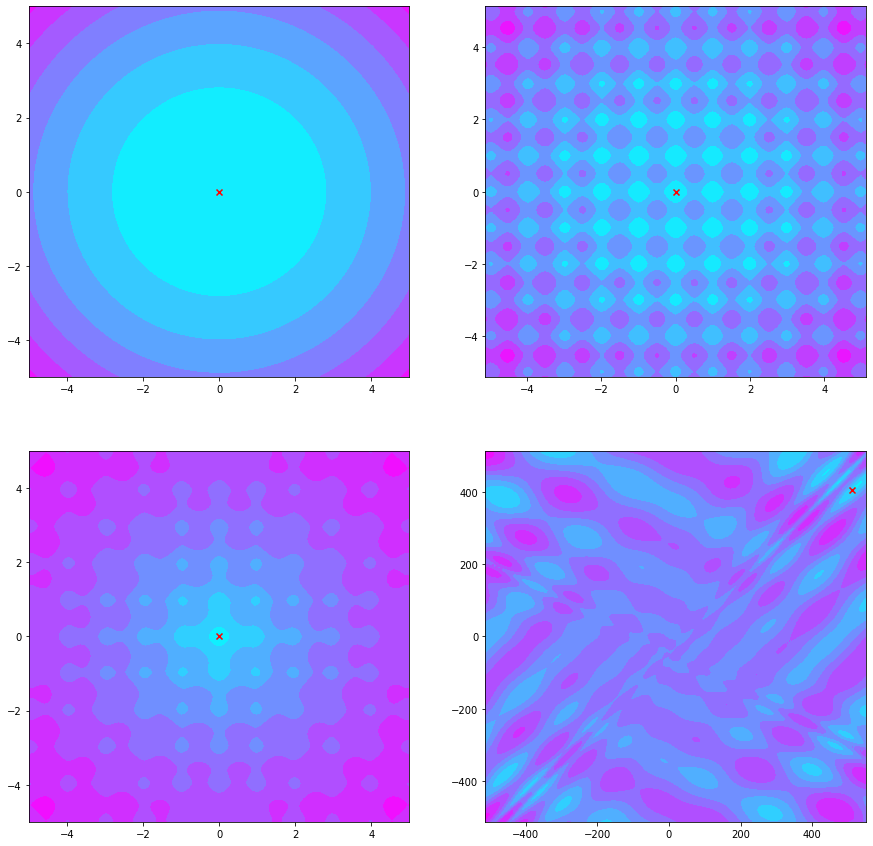

In [7]:
fig, ax = plt.subplots(2,2)
plt.set_cmap('cool')

# Plot for Sphere function
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X_SP, Y_SP = np.meshgrid(x, y)
SP = sphere([X_SP, Y_SP])
ax[0][0].contourf(X_SP, Y_SP, SP)
ax[0][0].scatter([0], [0], marker='x', color='red')

# Plot for Rastrigin function
x = np.linspace(-5.12, 5.12, 200)
y = np.linspace(-5.12, 5.12, 200)
X_RS, Y_RS = np.meshgrid(x, y)
RS = rastrigin([X_RS, Y_RS])
ax[0][1].contourf(X_RS, Y_RS, RS)
ax[0][1].scatter([0], [0], marker='x', color='red')

# Plot for Ackley function
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X_AK, Y_AK = np.meshgrid(x, y)
AK = ackley([X_AK, Y_AK])
ax[1][0].contourf(X_AK, Y_AK, AK)
ax[1][0].scatter([0], [0], marker='x', color='red')

# Plot for Eggholder function
x = np.linspace(-512, 550, 200)
y = np.linspace(-512, 512, 200)
X_EH, Y_EH = np.meshgrid(x, y)
EH = eggholder([X_EH, Y_EH])
ax[1][1].contourf(X_EH, Y_EH, EH)
ax[1][1].scatter([512], [404.2319], marker='x', color='red')

plt.show()

Qui definiamo le strategie evolutive con i paramtri `mu` e `lmb` che sono i valori $\mu$ e $\lambda$ delle ES.


In [8]:
class EvolutionStrategy(object):
    
    def __init__(self, mu, lmb, fit, limits, plus=False, stddev=0.5):
        self.mu = mu
        self.lmb = lmb
        self.plus = plus;
        self.fit = fit
        self.limits = limits
        self.pop = []
        self.stddev = 0.5
        for i in range(0,self.lmb):
            individual = []
            for lower, upper in self.limits:
                individual.append(random.uniform(lower, upper))
            self.pop.append(individual)
        self.best = min(self.pop, key=self.fit)
    
    def generation(self):
        self.truncated_selection()
        new_pop = []
        for i in range(0, self.lmb):
            new_ind = self.mutation(self.pop[i%self.mu])
            new_pop.append(new_ind)
        if self.plus:
            self.pop = self.pop + new_pop
        else:
            self.pop = new_pop
        candidate_best = min(self.pop, key=self.fit)
        if self.fit(self.best) > self.fit(candidate_best):
            self.best = candidate_best
    
    def mutation(self, individual):
        # This is siimply the addition of a gaussian noise to each coordinate.
        # There is the possibility of defining an *adaptive* mutation
        new_ind = []
        for i, coord in enumerate(individual):
            tmp = coord + random.gauss(0, self.stddev)
            if tmp < self.limits[i][0]:
                tmp = self.limits[i][0]
            if tmp > self.limits[i][1]:
                tmp = self.limits[i][1]
            new_ind.append(tmp)
        return new_ind
    
    def truncated_selection(self):
        list.sort(self.pop, key=self.fit)
        self.pop = self.pop[0:self.mu]
        
    def __str__(self):
        s = f"Best individual: {self.best}\n"
        s += f"with fitness {self.fit(best)}"
        return s

def display_pop2D(pop, ax):
    ax.scatter([x for x, y in pop], [y for x, y in pop], color='yellow')

In [10]:
def display_evolution(pop_list, row, columns, X, Y, function, opt=[0,0]):
    n_gen = len(pop_list) - 1;
    fig, ax = plt.subplots(row, columns)
    for i in range(0,row):
        for j in range(0,columns):
            ax[i][j].contourf(X, Y, function)
            ax[i][j].scatter(opt[0], opt[1], marker='x', color='red')
            gen = (columns*i+j)*(n_gen//(row*columns-1))
            display_pop2D(pop_list[gen], ax[i][j])
    plt.show()

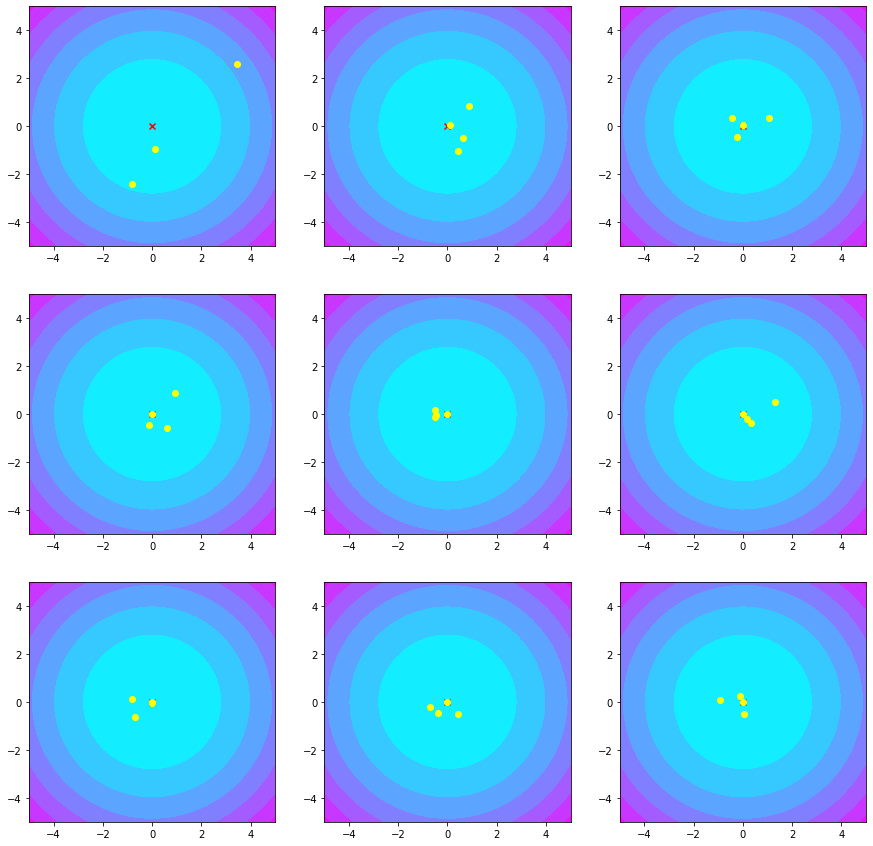

In [11]:
random.seed(0)
ES = EvolutionStrategy(1, 3, sphere, [[-5, 5], [-5, 5]], plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
display_evolution(pop_list, 3, 3, X_SP, Y_SP, SP)

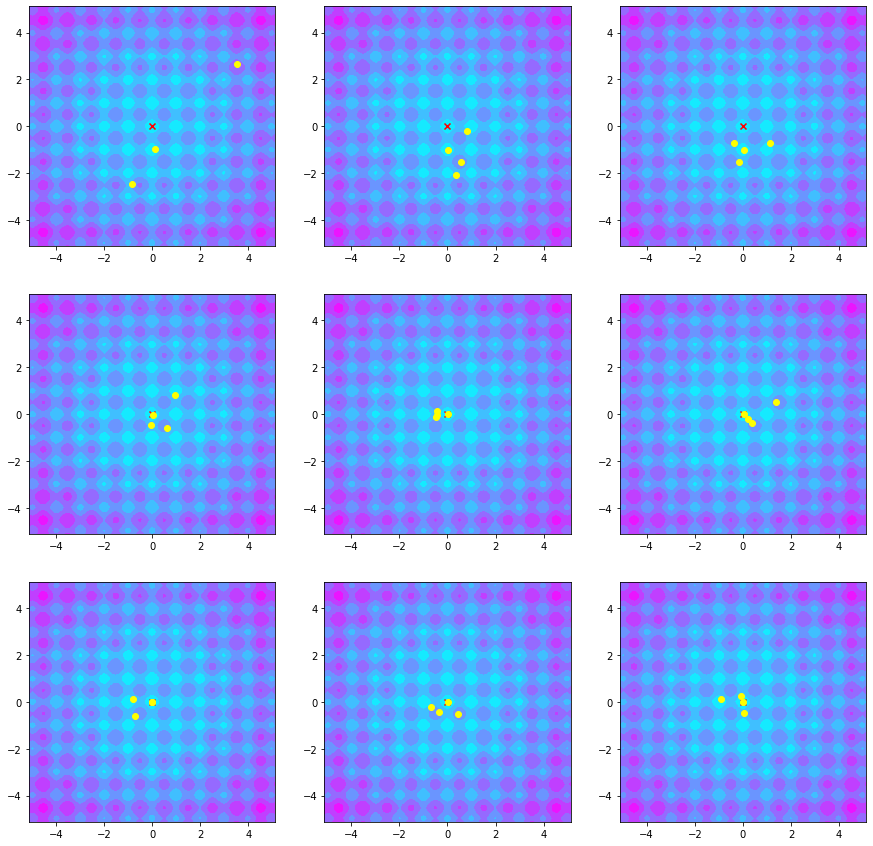

In [12]:
random.seed(0)
ES = EvolutionStrategy(1, 3, rastrigin, [[-5.12, 5.12], [-5.12, 5.12]], plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
display_evolution(pop_list, 3, 3, X_RS, Y_RS, RS)

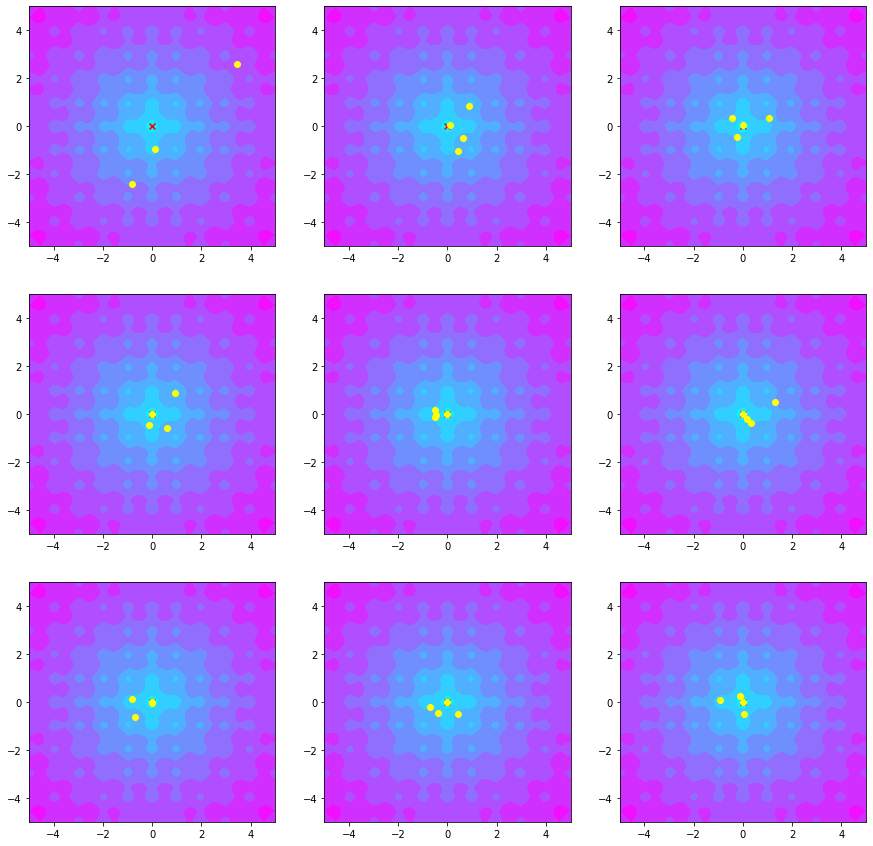

In [13]:
random.seed(0)
ES = EvolutionStrategy(1, 3, ackley, [[-5, 5], [-5, 5]], plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
display_evolution(pop_list, 3, 3, X_AK, Y_AK, AK)

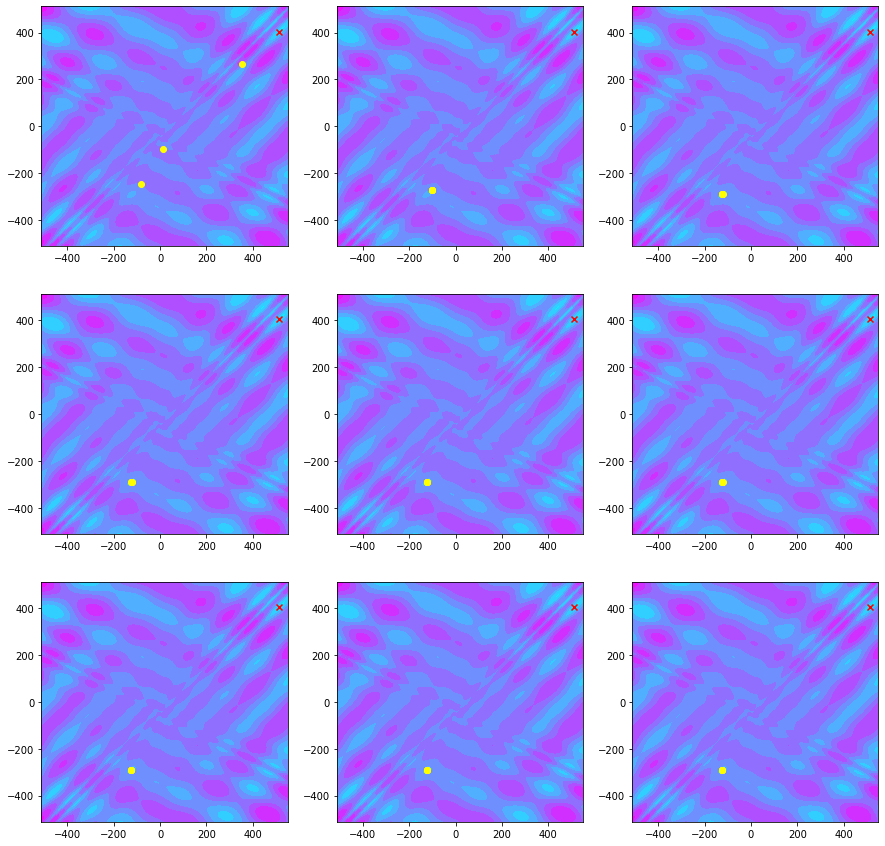

In [14]:
random.seed(0)
ES = EvolutionStrategy(1, 3, eggholder, [[-512, 512], [-512, 512]], plus=True, stddev=1)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
display_evolution(pop_list, 3, 3, X_EH, Y_EH, EH, opt=[512,404.2319])